In [26]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(cowplot)

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
download.file(url, "student.zip")
unzip("student.zip")
student_data <- read_delim("student-por.csv", delim=";") 
nrow(student_data)
nrow(filter(student_data, na.rm = TRUE))
# Since the number of rows before and after filter for missing observations is the same, there are no missing observations in the data
head(student_data)

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



[1] 649

[1] 649

school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,4,0,11,11
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,2,9,11,11
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,6,12,13,12
GP,F,15,U,GT3,T,4,2,health,services,⋯,3,2,2,1,1,5,0,14,14,14
GP,F,16,U,GT3,T,3,3,other,other,⋯,4,3,2,1,2,5,0,11,13,13
GP,M,16,U,LE3,T,4,3,services,other,⋯,5,4,2,1,2,5,6,12,12,13


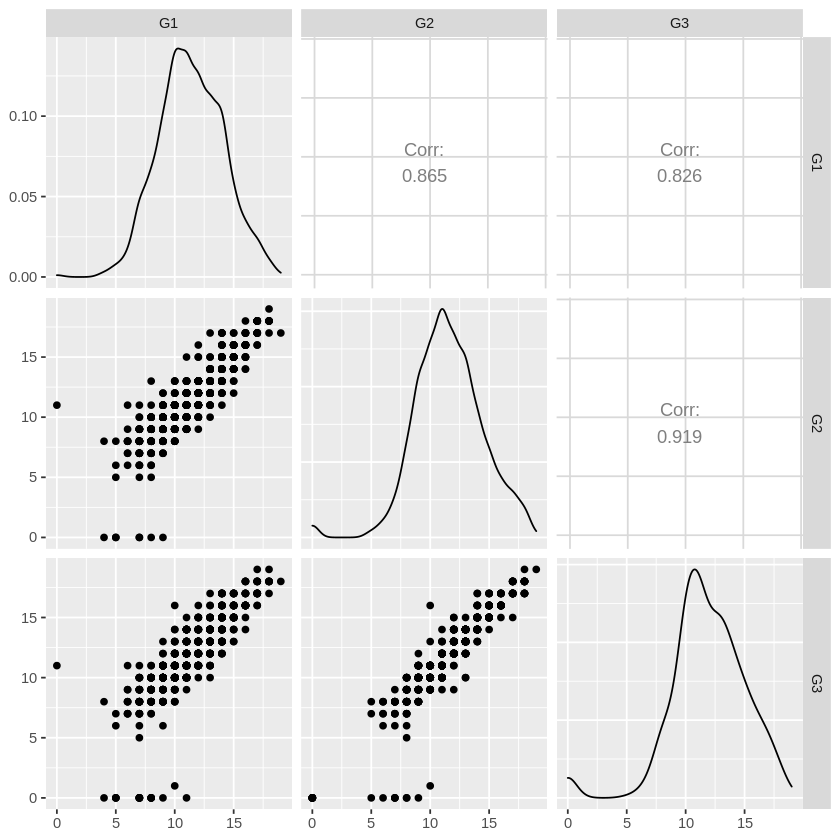

In [3]:
student_select <- select(student_data, G1, G2, G3)
predictor_visualization <- ggpairs(student_select)
predictor_visualization
# High correlation

In [4]:
set.seed(1234)
student_split <- initial_split(student_select, prop = 0.75, strata = G3)
student_training <- training(student_split) 
student_testing <- testing(student_split)
head(student_training)

G1,G2,G3
<dbl>,<dbl>,<dbl>
0,11,11
9,11,11
12,13,12
14,14,14
11,13,13
12,12,13


In [5]:
student_statistics <- student_training %>%
summarize("Number of Rows" = nrow(student_training),
         "Mean of G1" = mean(G1),
         "Mean of G2" = mean(G2),
         "Mean of G3" = mean(G3),
         "Median of G1" = median(G1),
         "Median of G2" = median(G2),
         "Median of G3" = median(G3))
student_statistics

Number of Rows,Mean of G1,Mean of G2,Mean of G3,Median of G1,Median of G2,Median of G3
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
488,11.37295,11.58607,11.89754,11,11,12


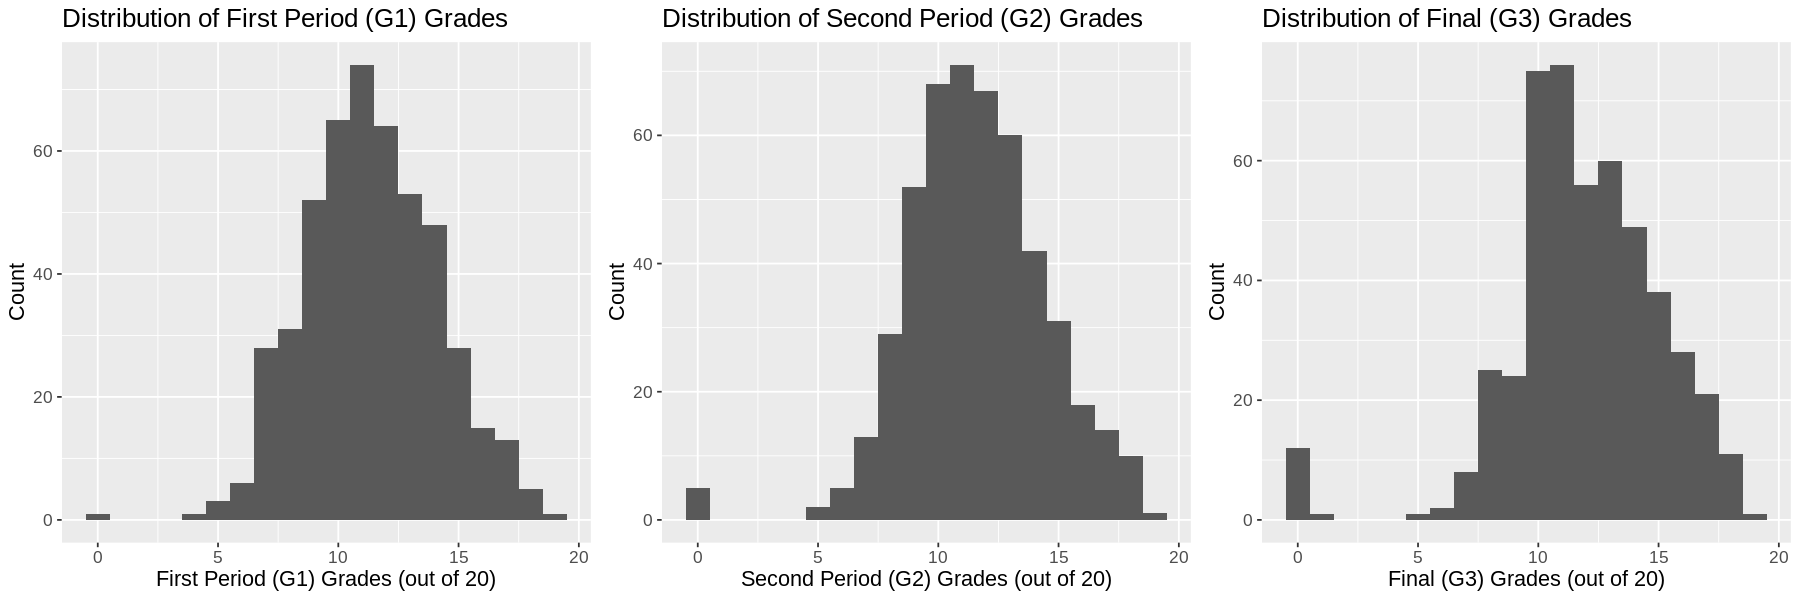

In [25]:
options(repr.plot.width = 15, repr.plot.height = 5)
g1_distribution <- ggplot(student_training, aes(x = G1))+
geom_histogram(bins = 20)+
labs(x = "First Period (G1) Grades (out of 20)", y = "Count")+
theme(text = element_text(size = 13))+
ggtitle("Distribution of First Period (G1) Grades")
g2_distribution <- ggplot(student_training, aes(x = G2))+
geom_histogram(bins = 20)+
labs(x = "Second Period (G2) Grades (out of 20)", y = "Count")+
theme(text = element_text(size = 13))+
ggtitle("Distribution of Second Period (G2) Grades")
g3_distribution <- ggplot(student_training, aes(x = G3))+
geom_histogram(bins = 20)+
labs(x = "Final (G3) Grades (out of 20)", y = "Count")+
ggtitle("Distribution of Final (G3) Grades")+
theme(text = element_text(size = 13))
predictor_distribution <- plot_grid(g1_distribution,
                                    g2_distribution,
                                    g3_distribution,
                                    ncol = 3)
predictor_distribution

In [7]:
student_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = tune()) %>%
set_engine("kknn") %>%
set_mode("regression")
student_spec

K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [8]:
student_recipe <- recipe(G3 ~ G1 + G2, data = student_training) %>%
step_scale(all_predictors()) %>%
step_center(all_predictors())
student_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [9]:
student_vfold <- vfold_cv(student_training, v = 10, strata = G3)
student_workflow <- workflow() %>%
add_recipe(student_recipe) %>%
add_model(student_spec)
student_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [10]:
gridvals <- tibble(neighbors = seq(from = 1, to = 200)) 
student_results <- student_workflow %>%
tune_grid(resamples = student_vfold, grid = gridvals) %>%
collect_metrics()
head(student_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,1.7567797,10,0.15862691,Model001
1,rsq,standard,0.7221983,10,0.03950129,Model001
2,rmse,standard,1.5826320,10,0.17761345,Model002
2,rsq,standard,0.7579105,10,0.04408261,Model002
3,rmse,standard,1.5638047,10,0.13729703,Model003
3,rsq,standard,0.7627604,10,0.03389215,Model003


In [11]:
student_min <- student_results %>%
filter(.metric == 'rmse') %>%
arrange(mean) %>%
slice(1)
student_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
8,rmse,standard,1.407227,10,0.1243025,Model008


In [12]:
k_min <- student_min %>%
pull(neighbors)
k_min

[1] 8

In [13]:
student_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
set_engine("kknn") %>%
set_mode("regression")
student_best_spec

K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = k_min
  weight_func = rectangular

Computational engine: kknn 


In [14]:
student_best_fit <- workflow() %>%
add_recipe(student_recipe) %>%
add_model(student_best_spec) %>%
fit(data = student_training)
student_best_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~k_min,     kernel = ~"rectangular")

Type of response variable: continuous
minimal mean absolute error: 0.8706455
Minimal mean squared error: 1.878298
Best kernel: rectangular
Best k: 8

In [15]:
student_summary <- predict(student_best_fit, student_testing) %>%
bind_cols(student_testing) %>%
metrics(truth = G3, estimate = .pred) %>%
filter(.metric == "rmse")
student_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.043363


In [28]:
student_min %>% pull(mean)
student_summary %>% pull(.estimate)
# the rmpse from testing data is better than the cross-validation rmse of our best model 
# so we are not doing worse on the testing data compared to the training data

[1] 1.407227

[1] 1.043363